<a href="https://colab.research.google.com/github/steveLim0928/Foundation-in-ML/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

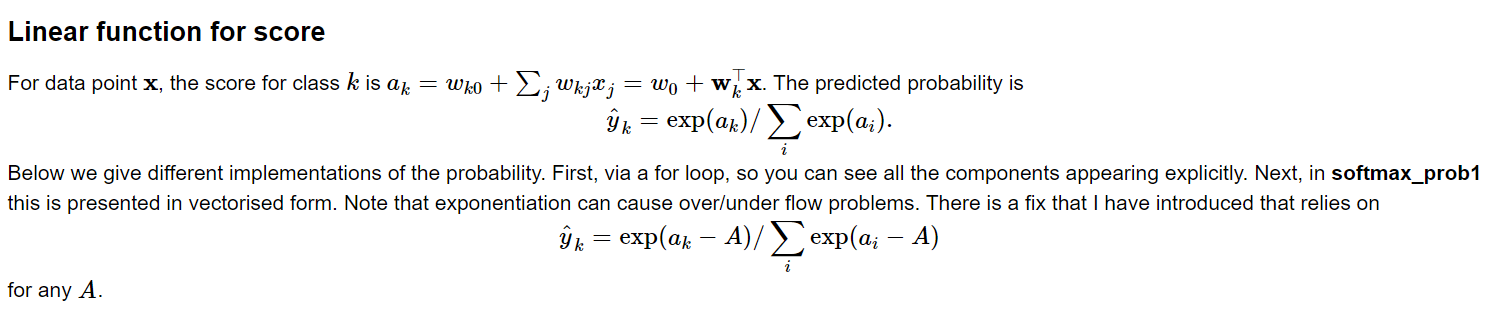

In [ ]:
def softmax_prob_forloop(W, b, inputs): # output is datalen-by-C (NumPy, no JAX here)
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    dim, datalen = np.shape(inputs) # how many dimensions, points
    c = len(b) # number of classes, C, each class has a bias 
    score = np.zeros((c, datalen))
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = b[ci] # w0, bias 
            for dk in range(dim):
                score[ci, lj] += W[ci, dk]*inputs[dk, lj]
    maxes = np.zeros(datalen)
    for lj in range(datalen):
        maxes[lj] = np.max(score[:, lj]) # max for each data pt
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = score[ci, lj] - maxes[lj]
    # subtract off the largest score from the bias of each class 
    # This is for stability to underflow/overflow when exponentiating
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0)) # sum of col
    return np.dot(expscore, norm_factor).T  


# below we convert the same steps into vector form, hence no for loops

def softmax_prob1(W, b, inputs):  # output is datalen-by-C
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(b) # number of classes, C, each class has a bias 
    linear_part = jnp.dot(W, inputs) # (C-by-dim)*(dim-by-datalen) = C-by-datalen
    large = jnp.max(linear_part, axis=0) # largest of the class scores for each data point
    bias_offset = jnp.dot(jnp.diag(b),jnp.ones((c, datalen))) # (C-by-C)*(C-by-L)
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T 

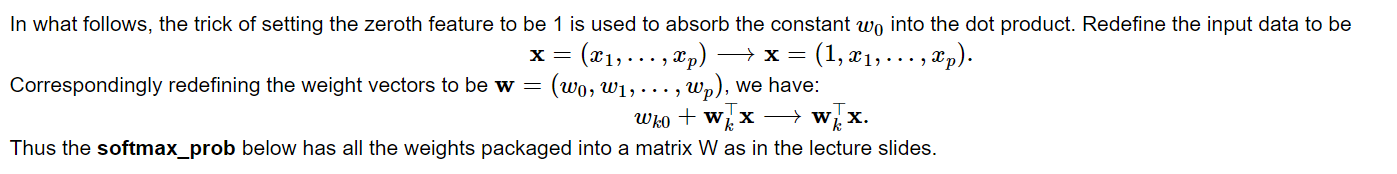

In [ ]:
def softmax_prob(W, inputs):  
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1] # how many points
    c = len(W) # number of classes, C, each class has a bias
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0) #redefine data input
    # create inputs (dim+1)-by-datalen 
    score = jnp.dot(W,inputs) 
    # (C-by-(1+dim))*((1+dim)-by-datalen) = C-by-datalen
    large = jnp.max(score, axis=0) # largest of the class scores for each data point
    # subtract off the largest score from the bias of each class for stability to underflow/overflow
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) #  (C-by-L)*(L-by-L)    
    expscore = jnp.exp(score  - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T  

In [ ]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [ ]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [ ]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.5], [3., 4.0, 4.0, -2.5]]) #4x(3+1)
# Build a toy dataset: 6 3-dim points with C=4  targets dim-by-datalen
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [3.82, -6.11, 3.15],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39],
                   [0.14, -0.43, -1.69]]).T # transpose to make it a dim-by-datalen array # 3x6
targets = jnp.array([0, 1, 3, 2, 1, 2]) #actual output

In [ ]:
# Initialize random model coefficients
key = random.PRNGKey(0) #create pseudo random gen key
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


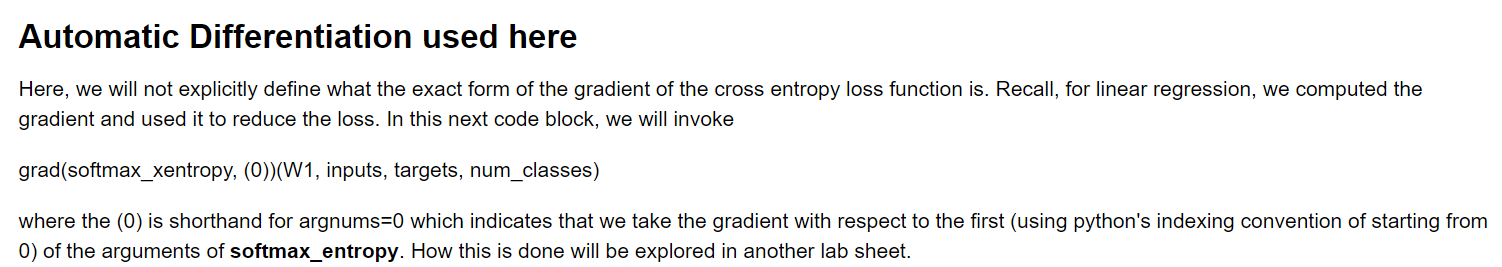

In [ ]:
def grad_descent(Wb, inputs, targets, num_classes,  lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):        
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))    
    return W1, Whist, losshist

In [ ]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 200)

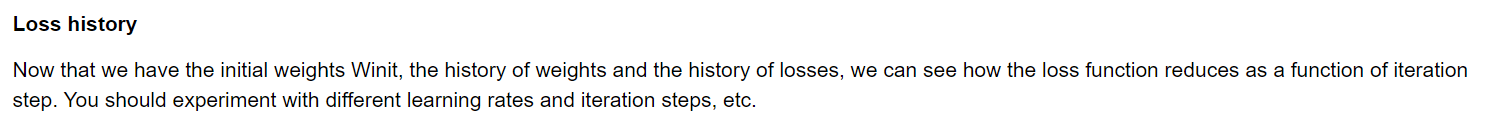

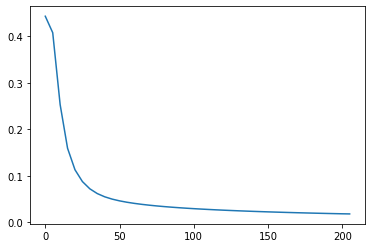

In [ ]:
plt.plot([5*i for i in range(len(losshist))], losshist) #append every 5 steps, so loss plot scale is 5

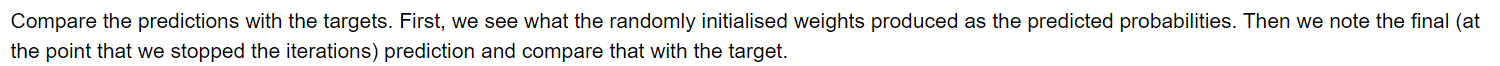

In [ ]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3)) # around = evenly round
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))

From:
 [[0.09       0.24300002 0.05       0.61800003]
 [0.         1.         0.         0.        ]
 [0.07300001 0.507      0.028      0.39200002]
 [0.011      0.002      0.025      0.9620001 ]
 [0.008      0.99000007 0.         0.002     ]
 [0.013      0.001      0.028      0.957     ]]
To:
 [[0.95100003 0.009      0.006      0.034     ]
 [0.         0.99600005 0.         0.004     ]
 [0.025      0.13000001 0.043      0.80200005]
 [0.004      0.         0.94900006 0.047     ]
 [0.001      0.92600006 0.         0.074     ]
 [0.         0.         0.97900003 0.021     ]]
Target:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


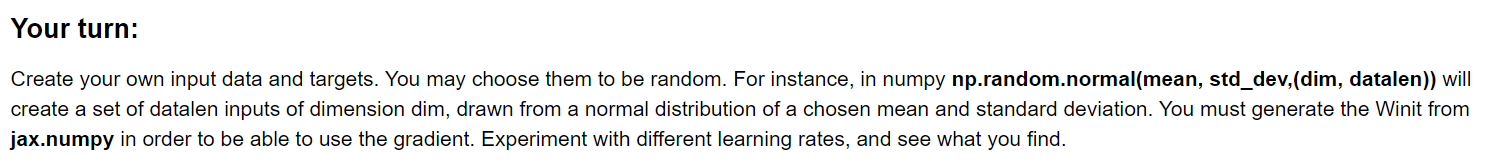

In [ ]:
# Initialize random model coefficients
key = random.PRNGKey(0) #create pseudo random gen key
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


In [ ]:
inputs = np.random.normal(1, 0.2, (10, 3)).T # 3 dim with 10 datalength
print(inputs)
targets = np.random.randint(4, size=10) # 4 classes
print(targets)

[[1.13754596 0.97769035 0.98875729 1.01884181 0.88348986 1.14384002
  0.68432989 0.78719733 0.72618776 1.09215216]
 [0.91534291 1.18016794 0.99200417 1.30083289 1.24277739 1.28840155
  0.87956957 1.22147429 0.77401487 1.37742451]
 [1.02545357 1.25764164 1.23676467 1.23827733 0.91358562 0.89707581
  0.84426068 1.08094265 0.63291475 1.15145214]]
[0 2 3 0 3 3 2 1 3 2]


In [ ]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.01, 5000)

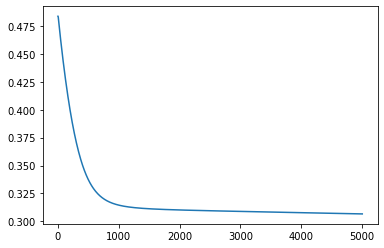

In [ ]:
plt.plot([5*i for i in range(len(losshist))], losshist)

In [ ]:
print('From:\n',np.around(softmax_prob(Winit, inputs),3))
print('To:\n',np.around(softmax_prob(W2, inputs),3))
print('Target:\n',get_one_hot(targets, 4))

From:
 [[0.053      0.46800002 0.029      0.45000002]
 [0.061      0.55300003 0.028      0.35700002]
 [0.059      0.601      0.025      0.314     ]
 [0.059      0.497      0.03       0.41400003]
 [0.064      0.28800002 0.04       0.60800004]
 [0.046      0.25800002 0.035      0.66      ]
 [0.083      0.356      0.041      0.51900005]
 [0.075      0.411      0.038      0.476     ]
 [0.074      0.25300002 0.043      0.63000005]
 [0.054      0.404      0.033      0.509     ]]
To:
 [[0.208      0.119      0.266      0.407     ]
 [0.25       0.132      0.33       0.289     ]
 [0.259      0.164      0.291      0.286     ]
 [0.231      0.105      0.35300002 0.31      ]
 [0.18100001 0.066      0.30900002 0.44300002]
 [0.15100001 0.052      0.30400002 0.49300003]
 [0.215      0.109      0.25       0.42600003]
 [0.22800002 0.09900001 0.32700002 0.34600002]
 [0.171      0.081      0.21000001 0.53800005]
 [0.2        0.078      0.35900003 0.363     ]]
Target:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0.

With random weights:

Small and large learning rate over 1k iteration still gives bad grad desc result. As expected, smaller rate reduces less loss over same no. of iteration as it has smaller steps. 

It would be better to start off with an educated weight guess instead of random, error is still very high even with 5k iteration for both small and large rate